In [1]:
# import all relevant packages
import pandas as pd
from pandas import DataFrame
from pandas import read_csv

import numpy as np
from numpy.polynomial import Polynomial

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
from datetime import datetime

import scipy
from scipy import fftpack
from scipy.signal import savgol_filter
from scipy.stats.stats import pearsonr

In [2]:
# import the data set 

# create a custom date parse function for the data
custom_date_parser = lambda x: datetime.strptime(x, "%d/%m/%Y")

# create an easy variable for the .csv file path
filename = r"C:\Users\Giorgio\Desktop\Dissertation_Main\Disseration\Data\Source_Data\MOD17A2H_GPP\statistics_Gpp_500m.csv"

# load in the .csv using pandas.read_csv and set the index as the column date 
df = read_csv(filename, header=0, parse_dates=[1], date_parser=custom_date_parser)

# inquire the dataframe
#df.info()
df.head(5)


,date[YYYYDDD],date,product,band,min,max,sum,range,mean,variance,standard_deviation,tot_pixels,pixels_pass_qa,per_cent_pixels_pass_qa
0,A2000049,2000-02-18,MOD17A2H,Gpp_500m,0.0040,0.0040,0.0040,0.0,0.0040,0.0,0.0,1,1,100
1,A2000057,2000-02-26,MOD17A2H,Gpp_500m,0.0355,0.0355,0.0355,0.0,0.0355,0.0,0.0,1,1,100
2,A2000065,2000-03-05,MOD17A2H,Gpp_500m,0.0305,0.0305,0.0305,0.0,0.0305,0.0,0.0,1,1,100
3,A2000073,2000-03-13,MOD17A2H,Gpp_500m,0.0412,0.0412,0.0412,0.0,0.0412,0.0,0.0,1,1,100
4,A2000081,2000-03-21,MOD17A2H,Gpp_500m,0.0358,0.0358,0.0358,0.0,0.0358,0.0,0.0,1,1,100


In [3]:
# set general plot paramters
plt.rcParams["figure.figsize"] = (40,15)
plt.rcParams.update({'font.size' : 24})

#df.set_index('date')
df = df[['date','mean','per_cent_pixels_pass_qa']]


In [4]:
df = df.rename(columns={'date':'Date', 'mean':'GPP_mean'})

In [5]:
# Clean bands data MOD19A1
#df_cl0 = df[df['per_cent_pixels_pass_qa'] == 100]
# clean the data and remove years beyond validation data 
df = df[df['per_cent_pixels_pass_qa'] != 0]

df

,Date,GPP_mean,per_cent_pixels_pass_qa
0,2000-02-18,0.0040,100
1,2000-02-26,0.0355,100
2,2000-03-05,0.0305,100
3,2000-03-13,0.0412,100
4,2000-03-21,0.0358,100
...,...,...,...
586,2012-11-24,0.0100,100
587,2012-12-02,0.0146,100
588,2012-12-10,0.0132,100
590,2012-12-26,0.0111,100


In [6]:
df = df.rename(columns={'GPP_mean':'GPP'})
df

,Date,GPP,per_cent_pixels_pass_qa
0,2000-02-18,0.0040,100
1,2000-02-26,0.0355,100
2,2000-03-05,0.0305,100
3,2000-03-13,0.0412,100
4,2000-03-21,0.0358,100
...,...,...,...
586,2012-11-24,0.0100,100
587,2012-12-02,0.0146,100
588,2012-12-10,0.0132,100
590,2012-12-26,0.0111,100


In [7]:
gppsg = savgol_filter(df['GPP'],21, 2, mode = 'mirror') # Savistky-Golay on a 2nd order polynomial function


In [8]:
df= df.set_index('Date')
df

,GPP,per_cent_pixels_pass_qa
Date,,
2000-02-18,0.0040,100
2000-02-26,0.0355,100
2000-03-05,0.0305,100
2000-03-13,0.0412,100
2000-03-21,0.0358,100
...,...,...
2012-11-24,0.0100,100
2012-12-02,0.0146,100
2012-12-10,0.0132,100


In [9]:
df_year = df.index.year # Extract the year from the DF index
df.insert(0, 'Year', df_year) # Add the year as the first column

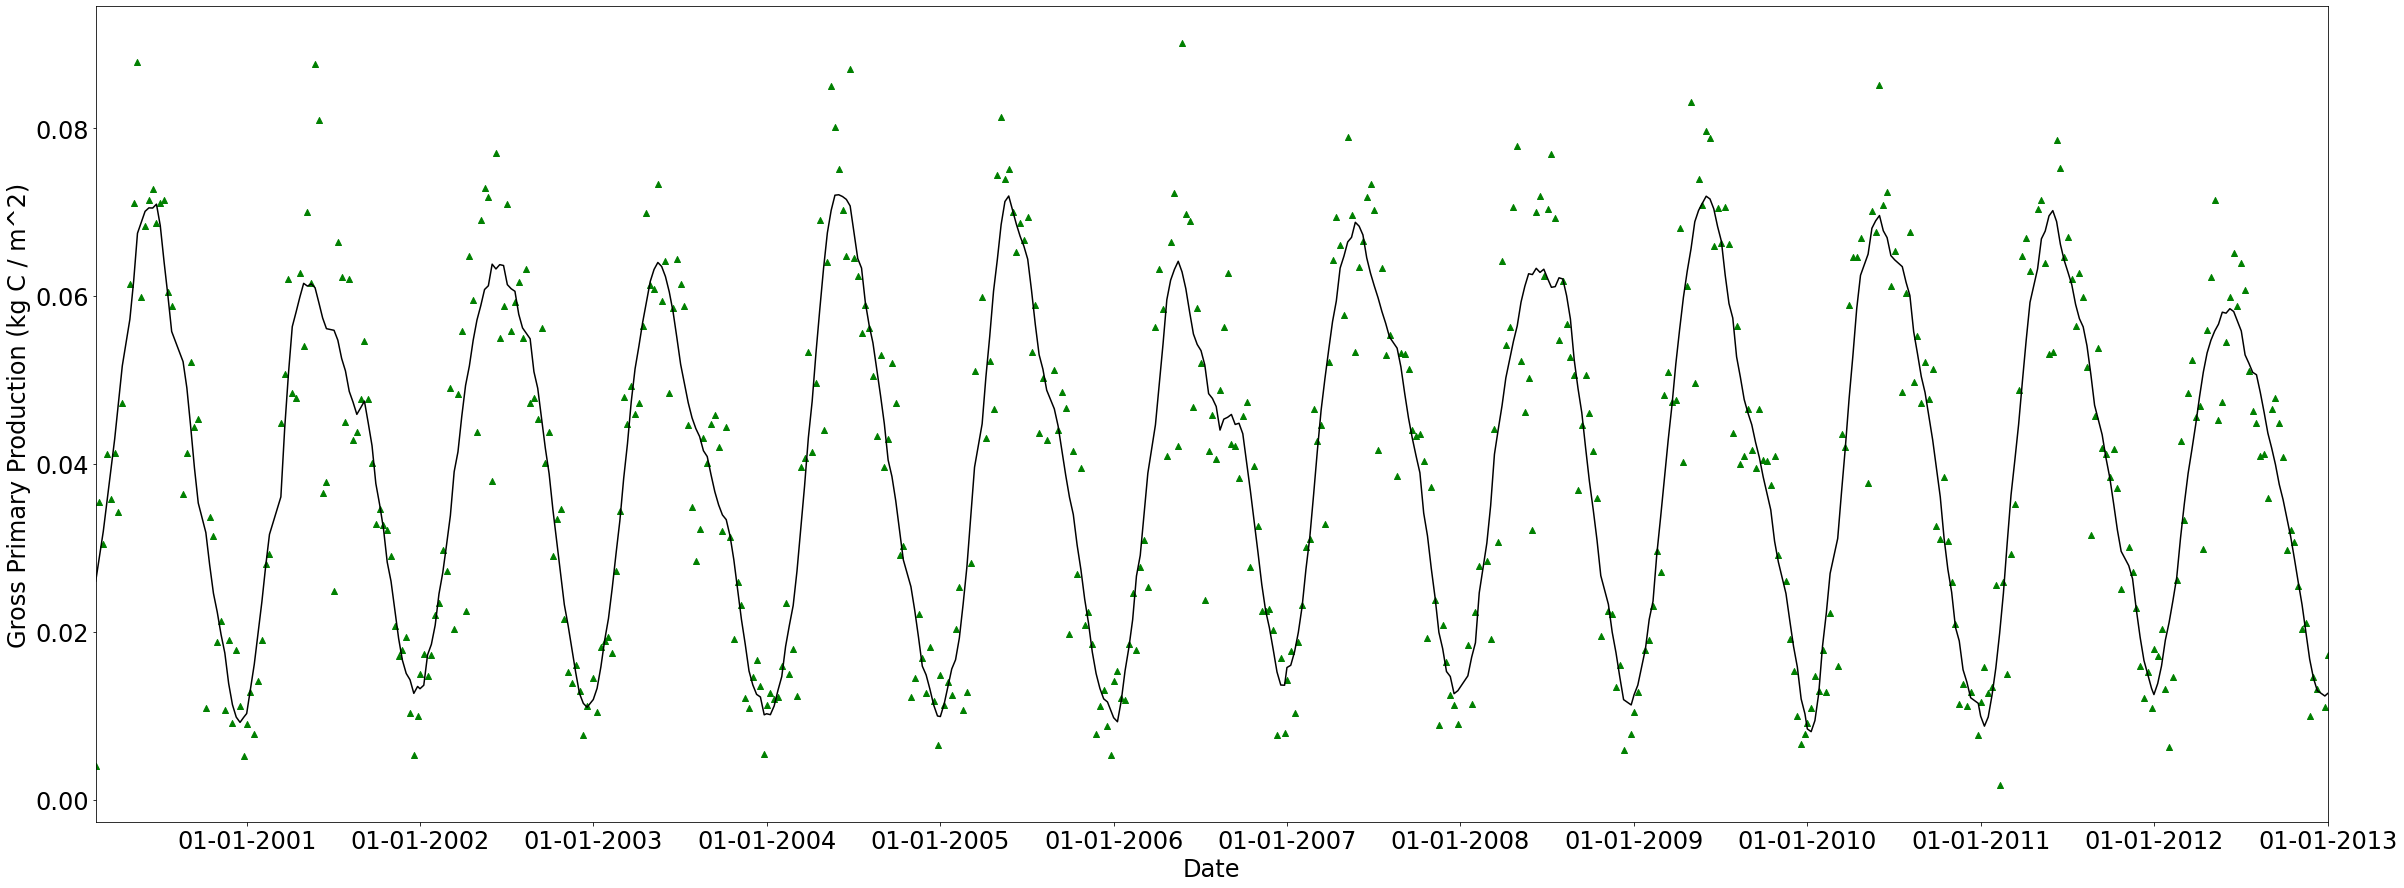

In [10]:
 fig, gpp = plt.subplots()

gpp.scatter(df.index, df['GPP'], color = 'green', marker ='^')

# set x-label 
gpp.set_xlabel('Date')
gpp.tick_params('x', labelsize =24)

# set primary y label
gpp.set_ylabel('Gross Primary Production (kg C / m^2)')

# define the plot for the secondary y

# set x-axis limits as the min and max of the series
gpp.set_xlim(date2num([df.index.min(), df.index.max()]))
gpp.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
gpp.xaxis.set_major_locator(mdates.YearLocator(month=1, day=1))

# plot the savitsky-golay flter

gpp.plot(df.index, gppsg, color = 'black')
plt.show() ##~

In [11]:
df['GPP_SG_FILT'] = gppsg

df_gs = df[['GPP_SG_FILT','Year']] # select only EVI and Year for 20th percentile calc
df_g_max = df_gs.groupby('Year').max() # Determine the max value in each year
df_g_min = df_gs.groupby('Year').min() # Determine the min value in each year


df_amp_join = df_g_max.join(df_g_min, 'Year', lsuffix ='Year' ) #  join the max and min df 


df_amp_join.rename(columns = {'GPP_SG_FILTYear':'GPP_SG_FILT_MAX','GPP_SG_FILT': 'GPP_SG_FILT_MIN'}, inplace = True) # rename columns 

df_amp_join

df_amp = df_amp_join # rename df 

df_amp['GPP_AMPLITUDE'] = df_amp['GPP_SG_FILT_MAX'] - df_amp['GPP_SG_FILT_MIN'] # calculate the amplitude of the yearly gpp change
df_amp['GPP_20th'] = df_amp['GPP_AMPLITUDE'].mul(.20) # determine the 20th percentile from the amplitude
df_amp['GPP_MINCORRECTED_20th'] = df_amp['GPP_SG_FILT_MIN'] + df_amp['GPP_20th'] # correct the 20th percentile for the min

#df_amp

In [12]:
df = df.join(df_amp, 'Year', how = 'left', lsuffix = 'Year') # join the two dataframes to include the max and 20th percentile

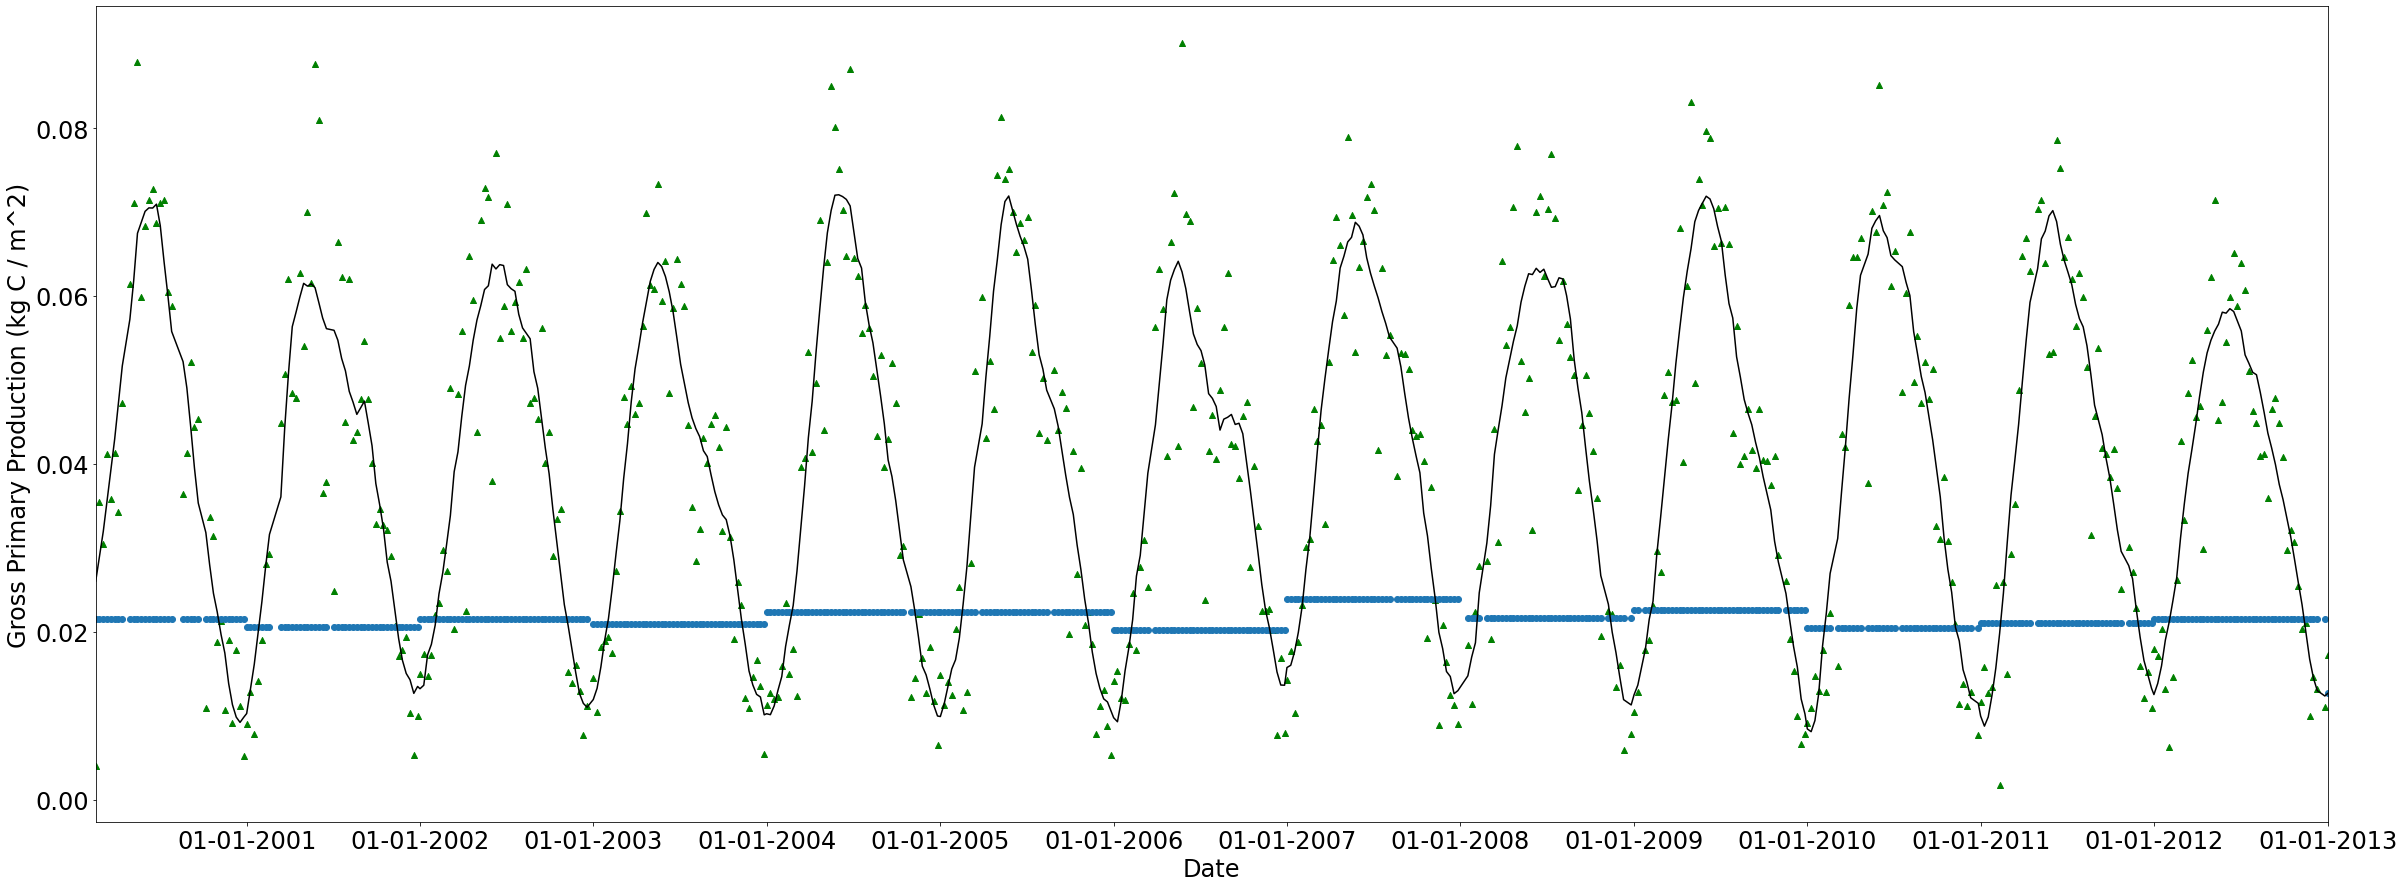

In [13]:
 fig, gpp = plt.subplots()

gpp.scatter(df.index, df['GPP'], color = 'green', marker ='^')

# set x-label 
gpp.set_xlabel('Date')
gpp.tick_params('x', labelsize =24)

# set primary y label
gpp.set_ylabel('Gross Primary Production (kg C / m^2)')

# define the plot for the secondary y

# set x-axis limits as the min and max of the series
gpp.set_xlim(date2num([df.index.min(), df.index.max()]))
gpp.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
gpp.xaxis.set_major_locator(mdates.YearLocator(month=1, day=1))

# plot the savitsky-golay flter

gpp.plot(df.index, gppsg, color = 'black')
gpp.scatter(df.index, df['GPP_MINCORRECTED_20th'])

plt.show()

In [14]:
# check if GPP_SG_FILT is less then Min_Corrected_Annual_20th%

# define a function which checks the value of the filtered SG value against the annual min corrected 20th percentile.
# if the value is less than the 20th% than FALSE, if greater it is TRUE
def check_df(df):
    if (df['GPP_SG_FILT'] < (df['GPP_MINCORRECTED_20th'])):
        return 0
    elif (df['GPP_SG_FILT'] > (df['GPP_MINCORRECTED_20th'])):
        return 1
    else:
        return np.nan


######
    
df['BoolCheck'] = df.apply(check_df, axis=1) # apply the function to the dataframe

######

# create another column which checks if the values in 'BoolCheck' change between rows.
# if they do than True, if they dont than false
df['changes'] = df["BoolCheck"].shift() != df["BoolCheck"] 

SC = df.loc[df['changes'] == True] # create a new df that only has values of change 

#######

SOS2 = SC.loc[SC['BoolCheck'] == 1] # filter for all the instances where the change goes from false to true, SOS

EOS2 = SC.loc[SC['BoolCheck'] == 0] # Now filter for all the instances where the change is from true to false, EOS


In [15]:


SOS1 = SOS2[['GPP_SG_FILT','BoolCheck', 'changes']] # only select relevant columns
EOS1 = EOS2[['GPP_SG_FILT','BoolCheck', 'changes']] # only select relevant columns 

#EOS = EOS1.set_index('date')
#SOS = SOS1.set_index('date')

#SOS = SOS.drop(['2001-03-22','2004-03-21','2006-03-06', '2007-12-27', '2009-01-01','2009-03-14','2010-03-30' ])
#EOS = EOS.drop(['2000-03-13', '2002-01-01', '2005-01-09','2007-01-01' ,'2008-01-17','2009-01-09', '2010-01-17','2011-01-01'])

In [16]:
print(SOS1)
print(EOS1)

            GPP_SG_FILT  BoolCheck  changes
Date                                       
2000-02-18     0.026039        1.0     True
2001-02-02     0.023585        1.0     True
2002-02-10     0.024530        1.0     True
2003-02-02     0.021605        1.0     True
2004-02-26     0.023146        1.0     True
2005-02-18     0.023326        1.0     True
2006-02-10     0.021452        1.0     True
2007-02-10     0.027472        1.0     True
2008-02-10     0.024663        1.0     True
2009-02-10     0.023659        1.0     True
2010-02-10     0.022240        1.0     True
2011-02-18     0.024626        1.0     True
2012-02-10     0.023729        1.0     True
            GPP_SG_FILT  BoolCheck  changes
Date                                       
2000-11-08     0.019697        0.0     True
2001-11-17     0.019233        0.0     True
2002-11-09     0.020769        0.0     True
2003-11-17     0.018556        0.0     True
2004-11-16     0.019360        0.0     True
2005-11-09     0.021068        0

In [ ]:
#SOS = SOS1.reset_index()
#EOS = EOS1.reset_index()


#Season = SOS.join(EOS, SOS.index, lsuffix = 'date')


#Season = Season[['datedate','date']]

#Season['DateDelta'] = Season['date'] - Season['datedate']

#Season.rename(columns = {'datedate':'SOS_Date', 'date':'EOS_Date'})

In [17]:
SOS1.to_csv(r'C:\Users\Giorgio\Desktop\Dissertation_Main\Disseration\Data\Processed_Data\GPP_SoS.csv')
EOS1.to_csv(r'C:\Users\Giorgio\Desktop\Dissertation_Main\Disseration\Data\Processed_Data\GPP_EoS.csv')